In [1]:
import pandas as pd
import numpy as np
from scipy.stats import mode
from datetime import timedelta
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.colors as mcolors

from dateutil import relativedelta

import sys
if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")
    
from operator import attrgetter

In [2]:
url_base = 'https://getfile.dokpub.com/yandex/get/'

url_cust = 'https://disk.yandex.ru/d/JB_M7w52y4jY7w'
cust_df = pd.read_csv(url_base + url_cust, sep=',')

url_orders = 'https://disk.yandex.ru/d/bqLNd3Izy7fD6Q'
orders = pd.read_csv(url_base + url_orders, sep=',')

url_items = 'https://disk.yandex.ru/d/3A_oH6Dbhodm9A'
items = pd.read_csv(url_base + url_items, sep=',')

#### EDA и определение понятия "покупка"

##### Датафрейм с уникальными идентификаторами пользователей

In [3]:
cust_df[:1]

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP


In [4]:
cust_df.shape

(99441, 5)

In [5]:
cust_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 5 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   customer_id               99441 non-null  object
 1   customer_unique_id        99441 non-null  object
 2   customer_zip_code_prefix  99441 non-null  int64 
 3   customer_city             99441 non-null  object
 4   customer_state            99441 non-null  object
dtypes: int64(1), object(4)
memory usage: 3.8+ MB


Данные собраны нормально; 

customer_id — позаказный идентификатор пользователя

customer_unique_id —  уникальный идентификатор пользователя  (аналог номера паспорта)

customer_zip_code_prefix —  почтовый индекс пользователя

customer_city —  город доставки пользователя

customer_state —  штат доставки пользователя

##### Датафрейм с заказами

In [6]:
orders[:1]

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00


In [7]:
orders.shape

(99441, 8)

In [8]:
orders.dtypes

order_id                         object
customer_id                      object
order_status                     object
order_purchase_timestamp         object
order_approved_at                object
order_delivered_carrier_date     object
order_delivered_customer_date    object
order_estimated_delivery_date    object
dtype: object

In [9]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   order_id                       99441 non-null  object
 1   customer_id                    99441 non-null  object
 2   order_status                   99441 non-null  object
 3   order_purchase_timestamp       99441 non-null  object
 4   order_approved_at              99281 non-null  object
 5   order_delivered_carrier_date   97658 non-null  object
 6   order_delivered_customer_date  96476 non-null  object
 7   order_estimated_delivery_date  99441 non-null  object
dtypes: object(8)
memory usage: 6.1+ MB


In [10]:
orders.isna().sum()

order_id                            0
customer_id                         0
order_status                        0
order_purchase_timestamp            0
order_approved_at                 160
order_delivered_carrier_date     1783
order_delivered_customer_date    2965
order_estimated_delivery_date       0
dtype: int64

 Данные собраны с пробелами, есть пробелы по временным отметкам. Пробелы в колонках времени подтверждения оплаты, передачи в логистику, доставки заказа. 

order_id —  уникальный идентификатор заказа (номер чека)

customer_id —  позаказный идентификатор пользователя

order_status —  статус заказа

order_purchase_timestamp —  время создания заказа

order_approved_at —  время подтверждения оплаты заказа

order_delivered_carrier_date —  время передачи заказа в логистическую службу

order_delivered_customer_date —  время доставки заказа

order_estimated_delivery_date —  обещанная дата доставки

А вот статусом каждый заказ промаркирован, покупкой будем считать все заказы со статусами от высталвния счета до доставки: invoiced, processing, shipped, delivered

Расшифровка статусов: 

created —  создан

approved —  подтверждён

invoiced —  выставлен счёт

processing —  в процессе сборки заказа

shipped —  отгружен со склада

delivered —  доставлен пользователю

unavailable —  недоступен

canceled —  отменён

In [11]:
orders.order_status.unique() # см уникальные статусы заказов

array(['delivered', 'invoiced', 'shipped', 'processing', 'unavailable',
       'canceled', 'created', 'approved'], dtype=object)

In [12]:
purchase = ['invoiced', 'processing', 'shipped', 'delivered'] # статусы, соотвествующие определению "покупка"

In [13]:
orders_copy = orders.query('order_status == @purchase')

In [14]:
orders_copy_2=orders_copy.groupby('order_status', as_index=False) \
        .agg({'order_id':'count'}).sort_values('order_id', ascending = False)
orders_copy_2

,order_status,order_id
0,delivered,96478
3,shipped,1107
1,invoiced,314
2,processing,301


##### Третий датафрейм с товарами заказов

In [15]:
items.shape

(112650, 7)

In [16]:
items.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112650 entries, 0 to 112649
Data columns (total 7 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   order_id             112650 non-null  object 
 1   order_item_id        112650 non-null  int64  
 2   product_id           112650 non-null  object 
 3   seller_id            112650 non-null  object 
 4   shipping_limit_date  112650 non-null  object 
 5   price                112650 non-null  float64
 6   freight_value        112650 non-null  float64
dtypes: float64(2), int64(1), object(4)
memory usage: 6.0+ MB


In [17]:
items.describe()

,order_item_id,price,freight_value
count,112650.000000,112650.000000,112650.000000
mean,1.197834,120.653739,19.990320
std,0.705124,183.633928,15.806405
min,1.000000,0.850000,0.000000
25%,1.000000,39.900000,13.080000
50%,1.000000,74.990000,16.260000
75%,1.000000,134.900000,21.150000
max,21.000000,6735.000000,409.680000


 Данные собраны нормально - кол-во наблюдений, отсутствие пропусков - всё ок. 

order_id —  уникальный идентификатор заказа (номер чека)

order_item_id —  идентификатор товара внутри одного заказа

product_id —  ид товара (аналог штрихкода)

seller_id — ид производителя товара

shipping_limit_date —  максимальная дата доставки продавцом для передачи заказа партнеру по логистике

price —  цена за единицу товара

freight_value —  вес товара

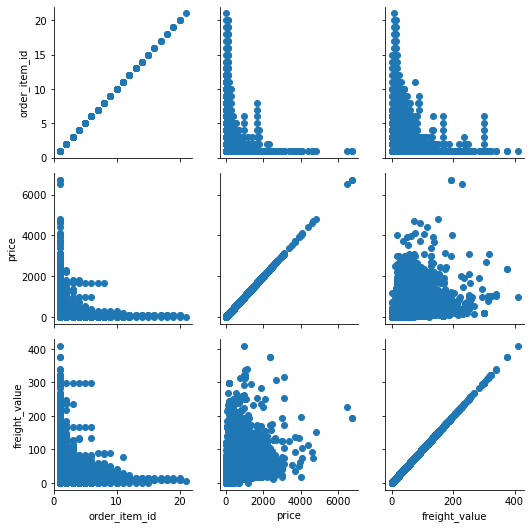

In [18]:
pair_grid_plot = sns.PairGrid(items) # можно посмотреть взаимосвязь переменных 
pair_grid_plot.map(plt.scatter)

Глобального инсайта попарное сравнение не дало.

Пара order_item_id / price (колво позиций в заказе / цена заказа) говорит о высоком спросе на недорогие товары, но также можно говорить о наличии в ассортимете товаров с ценником выше 6к за штуку;

По паре freight_value / price (вес / цена) видно, что большой вес не гарантирует высокую цену - есть как легкие дорогие, так и легкие дешевые заказы (если добавить данные об объеме коробок, цене логистики можно делать дополнительный анализ рентабельности доставки с целью, к примеру, принять решение о платной доставке для товаров весом от n-кг) 

***

#### 1.Расчет числа пользователей совершивших только одну покупку 

In [19]:
# По датасету с заказами считаем кол-во покупок каждого пользователя, далее выделяем тех, у кого только 1 заказ:

order_one = orders.query('order_status == @purchase').groupby("customer_id", as_index=False) \
    .agg({"order_id":"count"}) \
    .rename(columns={"order_id": "order_quantity"})

In [20]:
order_one.query('order_quantity == 1')['customer_id'].count()

98200

In [21]:
# При проверке датасета с данными пользователей, можно заметить, что число customer_id больше, чем customer_unique_id

cust_df.customer_id.nunique() - cust_df.customer_unique_id.nunique()

3345

 Число customer_id больше, чем customer_unique_id (определено в EDA).
 Следовательно, у некоторых пользователей имеется несколько аккаунтов. Принимая это во внимание, можно рассчитать, сколько покупок 
 приходится на customer_unique_id
 
 Для этого требуется добавить данные по customer_unique_id к датасету с заказами и пересчитать кол-во купивших 1 раз заново по юник_ид

In [22]:
cust_df_1 = cust_df[{ 'customer_id', 'customer_unique_id'}]

In [23]:
order_two = orders.query('order_status == @purchase')

In [24]:
new_orders = order_two.merge(cust_df_1, how='left', on=['customer_id']) \
                        .groupby('customer_unique_id', as_index=False) \
                        .agg({'order_id':'count'}).query('order_id == 1') 

In [25]:
# Можно сделать вывод, что нужны уточнения, по какому параметру учитывать "пользователя" - разница более 6к

order_one.query('order_quantity == 1')['customer_id'].count() - new_orders.customer_unique_id.count()

6103

#### 2. Расчет среднего числа недоставленных заказов в месяц

In [26]:
# Недосталвенные заказы считаем по колонке статус заказа, а именно по занчениям: недоступен(unavailable) и отменен(canceled)
# Приводим данные по дате заказа к формату даты, отбираем недоставленные и считаем среднее кол-во в месяц

orders['order_purchase_month'] = pd.to_datetime(orders.order_purchase_timestamp).dt.to_period('M')

In [27]:
undelivered = orders.query('order_status == ["unavailable", "canceled"]') \
            .groupby(['order_purchase_month','order_status'], as_index=False) \
            .agg({'order_id':'count'}) \
            .groupby('order_status', as_index=False).agg({'order_id':'mean'}).round(0) \
            .rename(columns={'order_id':'mean_quantity'})

undelivered

,order_status,mean_quantity
0,canceled,26.0
1,unavailable,29.0


<AxesSubplot:xlabel='order_status', ylabel='mean_quantity'>

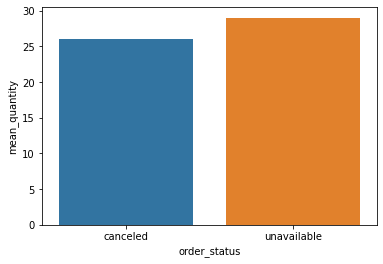

In [28]:
sns.barplot(x="order_status", y="mean_quantity", data=undelivered)

In [29]:
# А что если сравнить с доставленными в разрезе месяца? 

orders.query('order_status == ["delivered"]').groupby(['order_purchase_month','order_status'], as_index=False) \
      .agg({'order_id':'count'}) \
      .groupby('order_status', as_index=False).agg({'order_id':'mean'}).round(0) \
      .rename(columns={'order_id':'mean_quantity'})

,order_status,mean_quantity
0,delivered,4195.0


In [30]:
# В процентном соотношении - 1,3% не доставляются

np.round((26+29)/ 4195 * 100, 1)

1.3

#### 3. Определяем для каждого товара, в какой день недели он чаще всего покупается. 

In [31]:
# Извлекаем из даты заказа день недели в отдельную колонку, берем из датасета заказов order_id и день недели

orders['order_purchase_weekday'] = pd.to_datetime(orders.order_purchase_timestamp).dt.strftime('%A')
orders_by_weekday = orders[{ 'order_id', 'order_status','order_purchase_weekday'}]

In [32]:
prod_1 = items.merge(orders_by_weekday, how='left', on=['order_id'])
prod_1[:2]

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,order_purchase_weekday,order_status
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.9,13.29,Wednesday,delivered
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.9,19.93,Wednesday,delivered


In [33]:
# убираем строки с нерелевантным статусом

prod_1 = prod_1.query('order_status == @purchase') 

In [34]:
prod_2 = prod_1.groupby(["product_id", "order_purchase_weekday"], as_index=False) \
                .agg({"order_id": "count"}) \
                .sort_values(by="order_id", ascending=False) \
                .drop_duplicates(subset='product_id')
prod_2.rename(columns={'order_id':'count'}, inplace=True)
prod_2[:1]

,product_id,order_purchase_weekday,count
15815,422879e10f46682990de24d770e7f83d,Wednesday,93


In [35]:
prod_2.groupby('order_purchase_weekday', as_index=False) \
        .agg({'count':'sum'}) \
        .sort_values('count', ascending=False) # разбивка по дням недели, см когда больше всего заказов в штуках

,order_purchase_weekday,count
1,Monday,10117
5,Tuesday,9109
6,Wednesday,8491
0,Friday,8269
4,Thursday,8039
3,Sunday,5759
2,Saturday,4994


#### 4. Расчет среднего числа покупок на каждого пользователя  в неделю (по месяцам).

In [36]:
orders_pu = orders.query('order_status == @purchase')

In [37]:
orders_pu['order_purchase_D'] = pd.to_datetime(orders_pu.order_purchase_timestamp)

In [38]:
orders_pu['month'] = orders_pu['order_purchase_D'].dt.month

In [39]:
orders_pu.query('order_status == @purchase').isna().sum()

order_id                            0
customer_id                         0
order_status                        0
order_purchase_timestamp            0
order_approved_at                  14
order_delivered_carrier_date      617
order_delivered_customer_date    1730
order_estimated_delivery_date       0
order_purchase_month                0
order_purchase_weekday              0
order_purchase_D                    0
month                               0
dtype: int64

Нашли 14 заказов с неподтвержденной оплатой, рассмотрим их внимательнее: 

In [40]:
orders_pu[orders_pu['order_approved_at'].isnull()].groupby('order_status', as_index=False).agg({'order_id': 'count'})

,order_status,order_id
0,delivered,14


Все 14 заказов значатся доставленными, вероятнее всего ошибка при сборе данных - не проставились даты.

In [41]:
# Группируем по месяцам

orders_by_month = orders_pu.groupby(['customer_id', 'month',orders_pu.order_purchase_D.dt.month] \
                                           , as_index=False) \
                                           .agg({'order_id':'count'}) \
                                           .rename(columns = {'order_id':'total_orders'})

In [42]:
orders_by_month.dtypes

customer_id     object
month            int64
total_orders     int64
dtype: object

In [43]:
orders_by_month

,customer_id,month,total_orders
0,00012a2ce6f8dcda20d059ce98491703,11,1
1,000161a058600d5901f007fab4c27140,7,1
2,0001fd6190edaaf884bcaf3d49edf079,2,1
3,0002414f95344307404f0ace7a26f1d5,8,1
4,000379cdec625522490c315e70c7a9fb,4,1
...,...,...,...
98195,fffcb937e9dd47a13f05ecb8290f4d3e,3,1
98196,fffecc9f79fd8c764f843e9951b11341,3,1
98197,fffeda5b6d849fbd39689bb92087f431,5,1
98198,ffff42319e9b2d713724ae527742af25,6,1


После считаем среднее число покупок в неделю по месяцам
Используем следующие величины: Месяц, в котором 30 дней (апрель, июнь, сентябрь, ноябрь) - 30/7 = 4.29 (4 недели и 2 дня);
Месяц в котором 31 день (январь, март, май, июль, август, октябрь, декабрь) - 31/7 = 4.43 (4 недели и 3 дня);
Месяц в котором 28 дней (февраль) - 28/7 = 4 недели (невисокосный год).

In [44]:
def count_aver(x):
    if x.month in [4,6,9,11]:
        aver = x.total_orders / 4.29
    elif x.month == 2:
        aver = x.total_orders / 4
    else:
        aver = x.total_orders / 4.43
    return aver

In [45]:
orders_by_month['average_order'] = orders_by_month.apply(count_aver, axis=1)

In [46]:
orders_by_month.head()

,customer_id,month,total_orders,average_order
0,00012a2ce6f8dcda20d059ce98491703,11,1,0.233100
1,000161a058600d5901f007fab4c27140,7,1,0.225734
2,0001fd6190edaaf884bcaf3d49edf079,2,1,0.250000
3,0002414f95344307404f0ace7a26f1d5,8,1,0.225734
4,000379cdec625522490c315e70c7a9fb,4,1,0.233100


* * * 

#### 5. Когортный анализ пользователей и выявление когорты с самым высоким retention на 3й месяц в период с января по декабрь

In [47]:
orders = orders.merge(cust_df, on='customer_id') # добавляем данные с инфо о пользователях к заказам

In [48]:
orders.info() # проверяем наличие пропущенных значений

<class 'pandas.core.frame.DataFrame'>
Int64Index: 99441 entries, 0 to 99440
Data columns (total 14 columns):
 #   Column                         Non-Null Count  Dtype    
---  ------                         --------------  -----    
 0   order_id                       99441 non-null  object   
 1   customer_id                    99441 non-null  object   
 2   order_status                   99441 non-null  object   
 3   order_purchase_timestamp       99441 non-null  object   
 4   order_approved_at              99281 non-null  object   
 5   order_delivered_carrier_date   97658 non-null  object   
 6   order_delivered_customer_date  96476 non-null  object   
 7   order_estimated_delivery_date  99441 non-null  object   
 8   order_purchase_month           99441 non-null  period[M]
 9   order_purchase_weekday         99441 non-null  object   
 10  customer_unique_id             99441 non-null  object   
 11  customer_zip_code_prefix       99441 non-null  int64    
 12  customer_city     

In [49]:
orders.order_purchase_timestamp.min()

'2016-09-04 21:15:19'

In [50]:
orders.order_purchase_timestamp.max()

'2018-10-17 17:30:18'

Нужен полный год из наших наблюдений - можно взять 2017 с января по декабрь, также требуется отделить продажаи - статус delivered

In [51]:
orders17 = orders.query('"2016-12-31" < order_purchase_timestamp < "2018-01-01" \
                         & order_status == @purchase')

In [52]:
orders17['order_purchase_timestamp'] = pd.to_datetime(orders17['order_purchase_timestamp']) # приведение к DateTime

In [53]:
orders17.shape[0] - orders17.order_id.nunique() # повторяющихся заказов нет 

0

In [54]:
n_orders = orders.groupby(['customer_unique_id'])['order_id'].nunique() # кол-во уникальных заказов у каждого пользователя

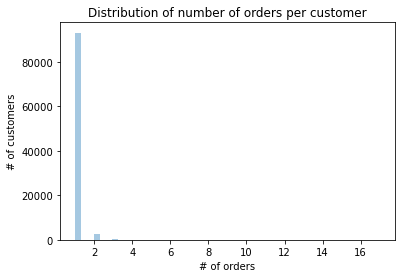

In [55]:
# дополнительно можно визуализировать распределение заказов по пользователям 
ax = sns.distplot(n_orders, kde=False, hist=True)
ax.set(title='Distribution of number of orders per customer',
       xlabel='# of orders', 
       ylabel='# of customers');

In [56]:
n_orders.max() # превалирующее большинство имеет по 1 заказу, из-за чего на графике сложно увидеть максимальное значение  
               # можно найти его через max 

17

In [57]:
#создаем колонки order_m - усеченный месяц с даты покупки и cohort - указывает ежемесячную когорту, основанную на дате первой покупки

orders17['order_m'] = orders17['order_purchase_timestamp'].dt.to_period('M')
orders17['cohort'] = orders17.groupby('customer_unique_id')['order_purchase_timestamp']\
    .transform('min').dt.to_period('M')

In [58]:
# агрегируем данные по когорте, месяцу первой покупки и считаем число уникальных покупателей в каждой группе

cohort17 = orders17.groupby(['cohort', 'order_m'])\
    .agg(uniq_orders=('customer_id', 'nunique'))\
    .reset_index(drop=False)
cohort17['period_number'] = (cohort17.order_m - cohort17.cohort).apply(attrgetter('n'))

In [59]:
# создаем pivot таблицу, где строка - инфо о когорте, а каждая колонка сожержит значение за каждый период
cohort_pivot = cohort17.pivot_table(index='cohort', columns='period_number', values='uniq_orders')

# создаем матрицу когорт
cohort_size = cohort_pivot.iloc[:, 0]
retention_matrix = cohort_pivot.divide(cohort_size, axis=0)

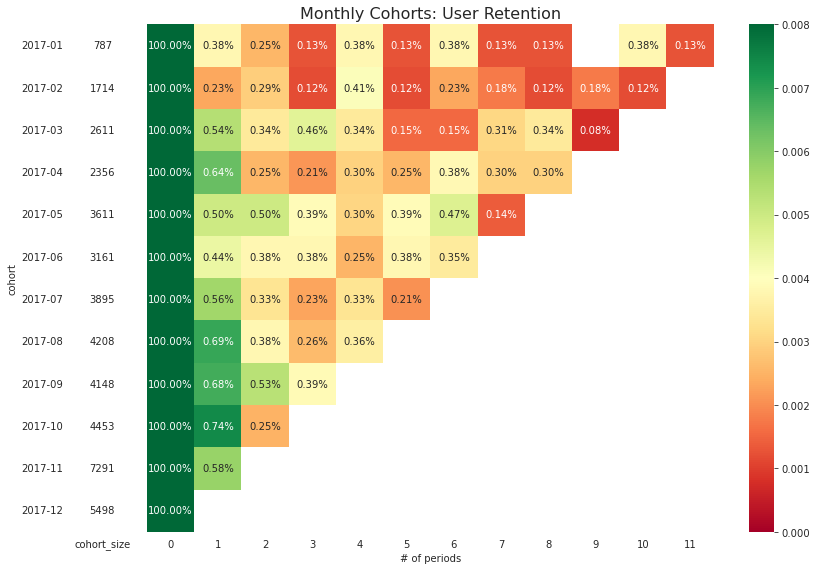

In [60]:
# тепловая карта когорт

with sns.axes_style("white"):
    fig, ax = plt.subplots(1, 2, figsize=(12, 8), sharey=True, gridspec_kw={'width_ratios': [1, 11]})
    
    sns.heatmap(retention_matrix.loc['2017-01-01':'2018-01-31'], 
                mask=retention_matrix.isnull(), 
                annot=True, 
                fmt='.2%', 
                vmin=0.0,
                vmax=0.008,
                cmap='RdYlGn', 
                ax=ax[1])
    ax[1].set_title('Monthly Cohorts: User Retention', fontsize=16)
    ax[1].set(xlabel='# of periods',
              ylabel='')
    
    cohort_size_df = pd.DataFrame(cohort_size).rename(columns={0: 'cohort_size'})
    white_cmap = mcolors.ListedColormap(['white'])
    sns.heatmap(cohort_size_df, 
                annot=True, 
                cbar=False, 
                fmt='g', 
                cmap=white_cmap, 
                ax=ax[0])

    fig.tight_layout()

Чемпион определен! Максимальный retention rate у когорты 2017-03.

* * * 

#### 6. RFM-сегментация пользователей

Метрики в кластеризации: 

R - время от последней покупки пользователя до текущей даты, 

F - суммарное количество покупок у пользователя за всё время, 

M - сумма покупок за всё время. 

In [61]:
# Соберем вместе все необходимые данные 

orders_extract = orders[['order_id', 'customer_id', 'order_status', 'order_purchase_timestamp']]

In [62]:
cust_extract = cust_df[['customer_id','customer_unique_id']]

In [63]:
rfm_df = items.merge(orders_extract, on='order_id')

In [64]:
rfm_df = rfm_df.merge(cust_extract, on='customer_id')

In [65]:
# Проверим размер нового датафрейма, 0 - всё ок, кол-во строк соответстует начальному с позициями товара

items['order_id'].count() - rfm_df['order_id'].count()

0

In [66]:
# Провреим, нет ли (случайно) позиций без ид пользователя. 0 == нет

rfm_df.customer_id.isna().sum()

0

In [67]:
rfm_df.dtypes

order_id                     object
order_item_id                 int64
product_id                   object
seller_id                    object
shipping_limit_date          object
price                       float64
freight_value               float64
customer_id                  object
order_status                 object
order_purchase_timestamp     object
customer_unique_id           object
dtype: object

In [68]:
# Преобразуем дату заказа в типу дата

rfm_df.order_purchase_timestamp = pd.to_datetime(rfm_df.order_purchase_timestamp)

In [69]:
rfm_df.order_status.unique()

array(['delivered', 'shipped', 'canceled', 'invoiced', 'processing',
       'approved', 'unavailable'], dtype=object)

In [70]:
# Оставляем в датафрейме только подтвержденные покупки  

rfm_df = rfm_df.query('order_status == @purchase')

In [71]:
print('Orders from {} to {}'.format(rfm_df['order_purchase_timestamp'].min(),
                                    rfm_df['order_purchase_timestamp'].max()))

Orders from 2016-09-04 21:15:19 to 2018-09-03 09:06:57


In [72]:
# Тепреь посчитаем стоимость каждой позиции, у нас нет кол-ва, но есть вес - перемножим их между собой, округлив до 2-х знаков

rfm_df['total_price'] = np.round((rfm_df.price * rfm_df.freight_value), 2)

In [73]:
# Проверяем, есть ли у нас заказы с кол-вом позиций больше 1 

rfm_df['order_id'].value_counts().head()

8272b63d03f5f79c56e9e4120aec44ef    21
1b15974a0141d54e36626dca3fdc731a    20
ab14fdcfbe524636d65ee38360e22ce8    20
9ef13efd6949e4573a18964dd1bbe7f5    15
428a2f660dc84138d969ccd69a0ab6d5    15
Name: order_id, dtype: int64

In [74]:
# В заказах есть как несколько позиций, так и одна - суммируем деньги заказов. Считаем, сколько раз клиент заказывал

rfm_orders = rfm_df.groupby(['order_id', 'customer_unique_id', 'order_purchase_timestamp'], as_index=False) \
                    .agg({'total_price': lambda x: x.sum()})

In [75]:
rfm_orders[:2]

,order_id,customer_unique_id,order_purchase_timestamp,total_price
0,00010242fe8c5a6d1ba2dd792cb16214,871766c5855e863f6eccc05f988b23cb,2017-09-13 08:59:02,782.78
1,00018f77f2f0320c557190d7a144bdd3,eb28e67c4c0b83846050ddfb8a35d051,2017-04-26 10:53:06,4781.21


In [76]:
# Далее делаем вид, что проводим анализ на следующий день после последней покупки. Эта дата пригодится для расчета Recency 

now = rfm_orders['order_purchase_timestamp'].max() + timedelta(days=1)

In [77]:
now

Timestamp('2018-09-04 09:06:57')

In [78]:
period = 365  # задаем период в год

Переходим к расчету Recency, Frequency and Monetary для каждого пользователя

In [79]:
# Добавляем колонку с количеством дней с последней покупки до нашего "now"

rfm_orders['days_since_order'] = rfm_orders['order_purchase_timestamp'].apply(lambda x: (now-x).days)

In [80]:
rfm_orders[:2]

,order_id,customer_unique_id,order_purchase_timestamp,total_price,days_since_order
0,00010242fe8c5a6d1ba2dd792cb16214,871766c5855e863f6eccc05f988b23cb,2017-09-13 08:59:02,782.78,356
1,00018f77f2f0320c557190d7a144bdd3,eb28e67c4c0b83846050ddfb8a35d051,2017-04-26 10:53:06,4781.21,495


In [81]:
rfm_orders.dtypes

order_id                            object
customer_unique_id                  object
order_purchase_timestamp    datetime64[ns]
total_price                        float64
days_since_order                     int64
dtype: object

In [82]:
rfm_table=rfm_orders.groupby('customer_unique_id').agg({'days_since_order': lambda x: x.min(), # Recency
                                                'order_purchase_timestamp': lambda x: len(x.unique()), # Frequency
                                                'total_price': lambda x: x.sum()})    # Monetary 

rfm_table.rename(columns={'days_since_order': 'Recency', 
                         'order_purchase_timestamp': 'Frequency',
                         'total_price': 'Monetary'}, inplace=True)
rfm_table.head()

,Recency,Frequency,Monetary
customer_unique_id,,,
0000366f3b9a7992bf8c76cfdf3221e2,116,1,1558.80
0000b849f77a49e4a4ce2b2a4ca5be3f,119,1,156.68
0000f46a3911fa3c0805444483337064,542,1,1188.18
0000f6ccb0745a6a4b88665a16c9f078,326,1,458.20
0004aac84e0df4da2b147fca70cf8255,293,1,3040.20


In [83]:
# Строим границы метрик. Для этого возьмем квантили 0.25, 0.5, 0.75 - каждый охватит 25% возможных значений

quantiles = rfm_table[['Recency', 'Frequency', 'Monetary']].quantile([.25, .5, 0.75]).to_dict()
quantiles

{'Recency': {0.25: 119.0, 0.5: 224.0, 0.75: 352.0},
 'Frequency': {0.25: 1.0, 0.5: 1.0, 0.75: 1.0},
 'Monetary': {0.25: 652.21, 0.5: 1434.99, 0.75: 3198.8}}

In [84]:
# Пишем функции для распределения по группам метрик

def r_score(x):
    if x <= quantiles['Recency'][.25]:
        return 4
    elif x <= quantiles['Recency'][.5]:
        return 3
    elif x <= quantiles['Recency'][.75]:
        return 2
    else:
        return 1
    
def fm_score(x, c):
    if x <= quantiles[c][.25]:
        return 1
    elif x <= quantiles[c][.5]:
        return 2
    elif x <= quantiles[c][.75]:
        return 3
    else:
        return 4

In [85]:
# Получаем r, f, m показатели для каждого клиента

rfm_table['R'] = rfm_table['Recency'].apply(lambda x: r_score(x))
rfm_table['F'] = rfm_table['Frequency'].apply(lambda x: fm_score(x, 'Frequency'))
rfm_table['M'] = rfm_table['Monetary'].apply(lambda x: fm_score(x, 'Monetary'))

In [86]:
# И теперь соединим r, f, m уровни а одну ячейку

rfm_table['RFM_Score'] = rfm_table['R'].map(str) + rfm_table['F'].map(str) + rfm_table['M'].map(str)
rfm_table.head()

,Recency,Frequency,Monetary,R,F,M,RFM_Score
customer_unique_id,,,,,,,
0000366f3b9a7992bf8c76cfdf3221e2,116,1,1558.80,4,1,3,413
0000b849f77a49e4a4ce2b2a4ca5be3f,119,1,156.68,4,1,1,411
0000f46a3911fa3c0805444483337064,542,1,1188.18,1,1,2,112
0000f6ccb0745a6a4b88665a16c9f078,326,1,458.20,2,1,1,211
0004aac84e0df4da2b147fca70cf8255,293,1,3040.20,2,1,3,213


### Итак, наши группы: 
###### Recency: 

1 от 347 до 365

2 от 220 до 346

3 от 115 до 219

4 от 0 до 114

######  Frequency: 

1 до 1

2 до 1

3 до 1

4 от 1 и выше

###### Monetary: 

1 от 3184 до 1 479 562.34

2 от 1430 до 3183.1

3 от 650 до 1429.83

4 от 0.0 до 649.9675

In [87]:
rfm_table.RFM_Score.nunique()

32

In [88]:
# дополнитетельно проверяем F, 4-ая группа - до 4 покупок

rfm_table.F.unique()

array([1, 4])

In [89]:
rfm_table.query('F == 4').count()[0] # присутствуют пользователи, сделавшие заказ 4 раза, их 2565 человек

2637

Рейтинг RFM дает 64 вариации, сократим до 6 сигментов: 

Best customers ---- Последняя покупка недавно, покупает часто

Loyal customers	--- Последня покупка относительно недавно, покупает часто

Potential Loyal ------Последняя покупка недавно, по покупает редко

Can't loose ---------	Последняя покупка давно, по раньше покупал часто - надо простимулировать, чтобы не потерять

Inactive -------------	Последняя покупка давно, покупал редко

New customers -----Новенькие 

In [90]:
segt_map = {
    r'[1-2][1-2]': 'Inactive',
    r'[1-2][3-4]': 'Сan\'t loose',
    r'3[1-2]': 'Potential Loyal',
    r'3[3-4]': 'Loyal customers',
    r'4[3-4]': 'Best customers',
    r'41': 'New customers'
}

rfm_table['Segment'] = rfm_table['R'].map(str) + rfm_table['F'].map(str)
rfm_table['Segment'] = rfm_table['Segment'].replace(segt_map, regex=True)
rfm_table[:5]

,Recency,Frequency,Monetary,R,F,M,RFM_Score,Segment
customer_unique_id,,,,,,,,
0000366f3b9a7992bf8c76cfdf3221e2,116,1,1558.80,4,1,3,413,New customers
0000b849f77a49e4a4ce2b2a4ca5be3f,119,1,156.68,4,1,1,411,New customers
0000f46a3911fa3c0805444483337064,542,1,1188.18,1,1,2,112,Inactive
0000f6ccb0745a6a4b88665a16c9f078,326,1,458.20,2,1,1,211,Inactive
0004aac84e0df4da2b147fca70cf8255,293,1,3040.20,2,1,3,213,Inactive


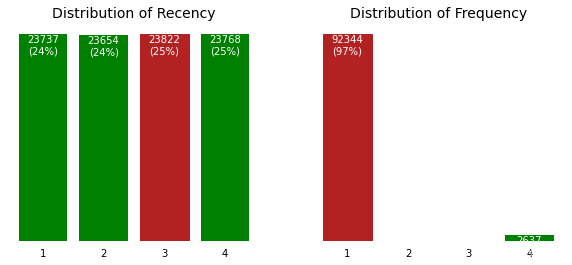

In [91]:
# Добавляем визуализацию по R и F

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

for i, p in enumerate(['R', 'F']):
    parameters = {'R':'Recency', 'F':'Frequency'}
    y = rfm_table[p].value_counts().sort_index()
    x = y.index
    ax = axes[i]
    bars = ax.bar(x, y, color='green')
    ax.set_frame_on(False)
    ax.tick_params(left=False, labelleft=False, bottom=False)
    ax.set_title('Distribution of {}'.format(parameters[p]),
                fontsize=14)
    for bar in bars:
        value = bar.get_height()
        if value == y.max():
            bar.set_color('firebrick')
        ax.text(bar.get_x() + bar.get_width() / 2,
                value - 5,
                '{}\n({}%)'.format(int(value), int(value * 100 / y.sum())),
               ha='center',
               va='top',
               color='w')

plt.show()

Вывод: практически равномерное распределение покупателей по давности последней покупки, самая многочисленная группа (25% и 23 451 человек) в группе 3  - последняя покупка 155-219 дней назад; 
группа 4 - последняя покупка 0-114 дней назад - вторая по численности.

Что касается частоты покупок большинство совершило покупку всего 1 раз, и всего 2 565 человек больше одного раза, это всего 3% 

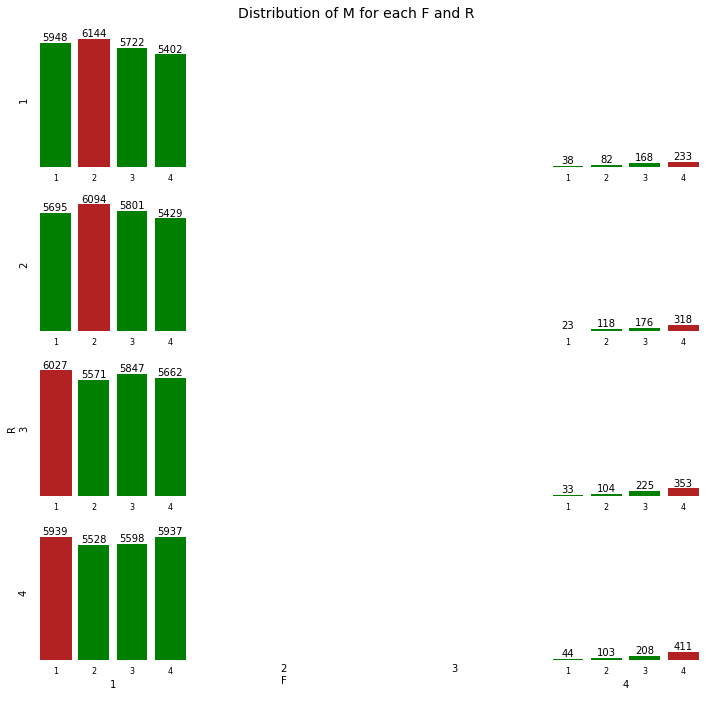

In [92]:
fig, axes = plt.subplots(nrows=4, ncols=4,
                         sharex=False, sharey=True,
                         figsize=(10, 10))

r_range = range(1, 5)
f_range = range(1, 5)
for r in r_range:
    for f in f_range:
        y = rfm_table[(rfm_table['R'] == r) & (rfm_table['F'] == f)]['M'].value_counts().sort_index()
        x = y.index
        ax = axes[r - 1, f - 1]
        bars = ax.bar(x, y, color='green')
        if r == 4:
            if f == 2:
                ax.set_xlabel('{}\nF'.format(f), va='top')
            else:
                ax.set_xlabel('{}\n'.format(f), va='top')
        if f == 1:
            if r == 3:
                ax.set_ylabel('R\n{}'.format(r))
            else:
                ax.set_ylabel(r)
        ax.set_frame_on(False)
        ax.tick_params(left=False, labelleft=False, bottom=False)
        ax.set_xticks(x)
        ax.set_xticklabels(x, fontsize=8)

        for bar in bars:
            value = bar.get_height()
            if value == y.max():
                bar.set_color('firebrick')
            ax.text(bar.get_x() + bar.get_width() / 2,
                    value,
                    int(value),
                    ha='center',
                    va='bottom',
                    color='k')
fig.suptitle('Distribution of M for each F and R',
             fontsize=14)
plt.tight_layout()
plt.show()

Вывод: Посмотрим на деньги. Очевидно, что бОльшую сумму принесли "разовые" покупатели, те,кто купил всего 1 раз. НО их 97%, поэтому неудивительно. Левая колонка. 

Правая колонка - те, кто возвращался за повторной покупкой. Больше всего денег потратили в наиболее активные (R и F - 4/4). Со увеличением даты последнего посещения (R) снижается сумма покупок. 

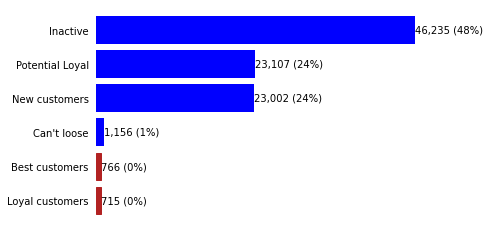

In [93]:
# Рассчитаем количества пользователей в каждом сигменте матрицы


segments_counts = rfm_table['Segment'].value_counts().sort_values(ascending=True)

fig, ax = plt.subplots()

bars = ax.barh(range(len(segments_counts)),
              segments_counts,
              color='blue')
ax.set_frame_on(False)
ax.tick_params(left=False,
               bottom=False,
               labelbottom=False)
ax.set_yticks(range(len(segments_counts)))
ax.set_yticklabels(segments_counts.index)

for i, bar in enumerate(bars):
        value = bar.get_width()
        if segments_counts.index[i] in ['Best customers', 'Loyal customers']:
            bar.set_color('firebrick')
        ax.text(value,
                bar.get_y() + bar.get_height()/2,
                '{:,} ({:}%)'.format(int(value),
                                   int(value*100/segments_counts.sum())),
                va='center',
                ha='left'
               )

plt.show()

Вывод: Показатели ужасные! 

48% покупателей неактивные - давно, редко покупали на маленькие суммы; 

другие 48% относятся пополам к пришедшим недавно и тем, кто редко покупает


Если бы не синтетический датафрейм, можно было бы подумать, что данные взяты с бизнеса, который обанкротился 

In [94]:
rfm_table.sort_values('Monetary', ascending=False).head()

,Recency,Frequency,Monetary,R,F,M,RFM_Score,Segment
customer_unique_id,,,,,,,,
ff4159b92c40ebe40454e3e6a7c35ed6,467,1,1479562.34,1,1,4,114,Inactive
dc4802a71eae9be1dd28f5d788ceb526,568,1,1308677.85,1,1,4,114,Inactive
459bef486812aa25204be022145caa62,40,1,1300110.09,4,1,4,414,New customers
95a744604de66a2e40e18086e69be4f2,59,1,980664.83,4,1,4,414,New customers
5e92460d739e8dd987e279285a1d278c,21,1,877434.66,4,1,4,414,New customers


Интереса ради посмотрим кто чемпионы по затраченным суммам: ТОП5 - неактивные пользователи и новые покупатели. Что подтверждает вывод сделанный выше)